In [5]:
import os
import random

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dataload
import torchvision.transforms as transforms
import torchvision.utils as vutils

In [6]:
os.listdir("/kaggle/input")

['animefacedataset']

In [7]:
dataroot = "/kaggle/input/animefacedataset"
workers = 2
batch_size = 128
image_size = 64
nc = 3
nz = 100
G = 64
D = 64
lr = 0.0002
beta1 = 0.5
ngpu = 2

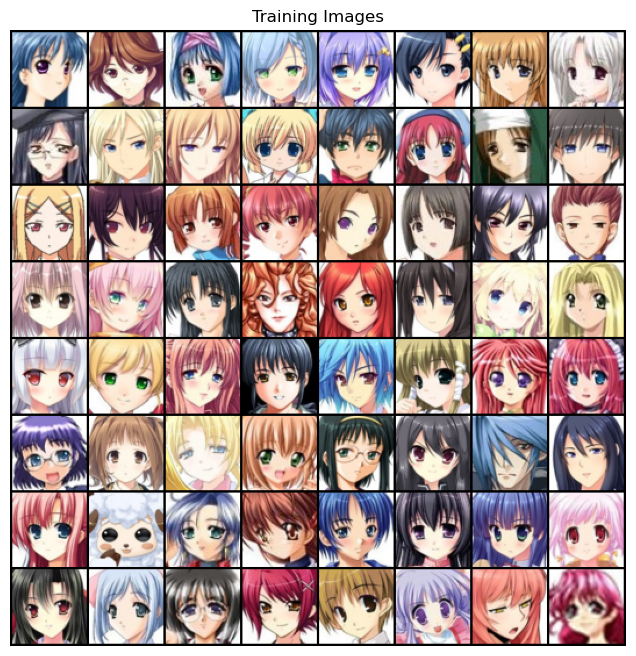

In [8]:
dataset = dataload.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [9]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [10]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super().__init__()
        self.latent_dim = latent_dim

        def block(in_channels, out_channels, normalize=True, ks=4, s=2, pad=1):
            layers = []
            layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size=ks, stride=s, padding=pad, bias=False))
            if normalize:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU(True))
            return layers

        self.model = nn.Sequential(
            *block(self.latent_dim, G * 8, normalize=False, s=1, pad=0),
            *block(G * 8, G * 4),
            *block(G * 4, G * 2),
            *block(G * 2, G),
            nn.ConvTranspose2d(in_channels=G, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )
        
    def forward(self, z):
        return self.model(z)
    
netG = Generator().to(device)

if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))
netG.apply(weights_init)

print(netG)

DataParallel(
  (module): Generator(
    (model): Sequential(
      (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): ReLU(inplace=True)
      (2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReLU(inplace=True)
      (5): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): ReLU(inplace=True)
      (8): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU(inplace=True)
      (11): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (12): Tanh()
    )
  )
)


In [11]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        def block(in_channels, out_channels, normalize=True):
            layers=[]
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False))
            if normalize:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(3, D, normalize=False),
            *block(D, D*2),
            *block(D*2, D*4),
            *block(D*4, D*8),
            nn.Conv2d(D*8, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid() 
        )

    def forward(self, img):
        return self.model(img)
    
netD = Discriminator().to(device)

if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
netD.apply(weights_init)

print(netD)

DataParallel(
  (module): Discriminator(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): LeakyReLU(negative_slope=0.2, inplace=True)
      (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): LeakyReLU(negative_slope=0.2, inplace=True)
      (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): LeakyReLU(negative_slope=0.2, inplace=True)
      (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
   

In [12]:
criterion = nn.BCELoss()
fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
img_list = []
G_losses = []
D_losses = []
D_xs = []
D_G_z1s = []
D_G_z2s = []

iters = 0
num_epochs = 30

import mlnotify

mlnotify.start()
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        optimizerD.zero_grad()
        
        real_data = data[0].to(device)
        b_size = real_data.size(0)
        
        targets = torch.ones(batch_size, 1, device=device)
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake_data = netG(noise)
        
        output = netD(real_data).view(-1)
        real_targets = torch.ones(real_data.size(0), 1, device=device)
        errD_real = criterion(output, real_targets.squeeze(1))
        errD_real.backward()
        D_x = output.mean().item()

        fake_targets = torch.zeros(fake_data.size(0), 1, device=device)
        output = netD(fake_data.detach()).view(-1)
        errD_fake = criterion(output, fake_targets.squeeze(1))
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        errD = (errD_real + errD_fake)/2

        optimizerD.step()

        optimizerG.zero_grad()
        output = netD(fake_data).view(-1)
        Gfake_targets = torch.ones_like(output)

        errG = criterion(output, Gfake_targets)
        errG.backward()
        D_G_z2 = output.mean().item()

        optimizerG.step()

        G_losses.append(errG.item())
        D_losses.append(errD.item())
        D_xs.append(D_x)
        D_G_z1s.append(D_G_z1)
        D_G_z2s.append(D_G_z2)

        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
        
    print('G_Loss : %.4f | D_Loss : %.4f | D(x) : %.4f | D(G(z)): %.4f/%.4f'%(G_losses[epoch],D_losses[epoch],D_xs[epoch],
                                                                              D_G_z1s[epoch],D_G_z2s[epoch]))

In [17]:
fake_data = netG(fixed_noise)

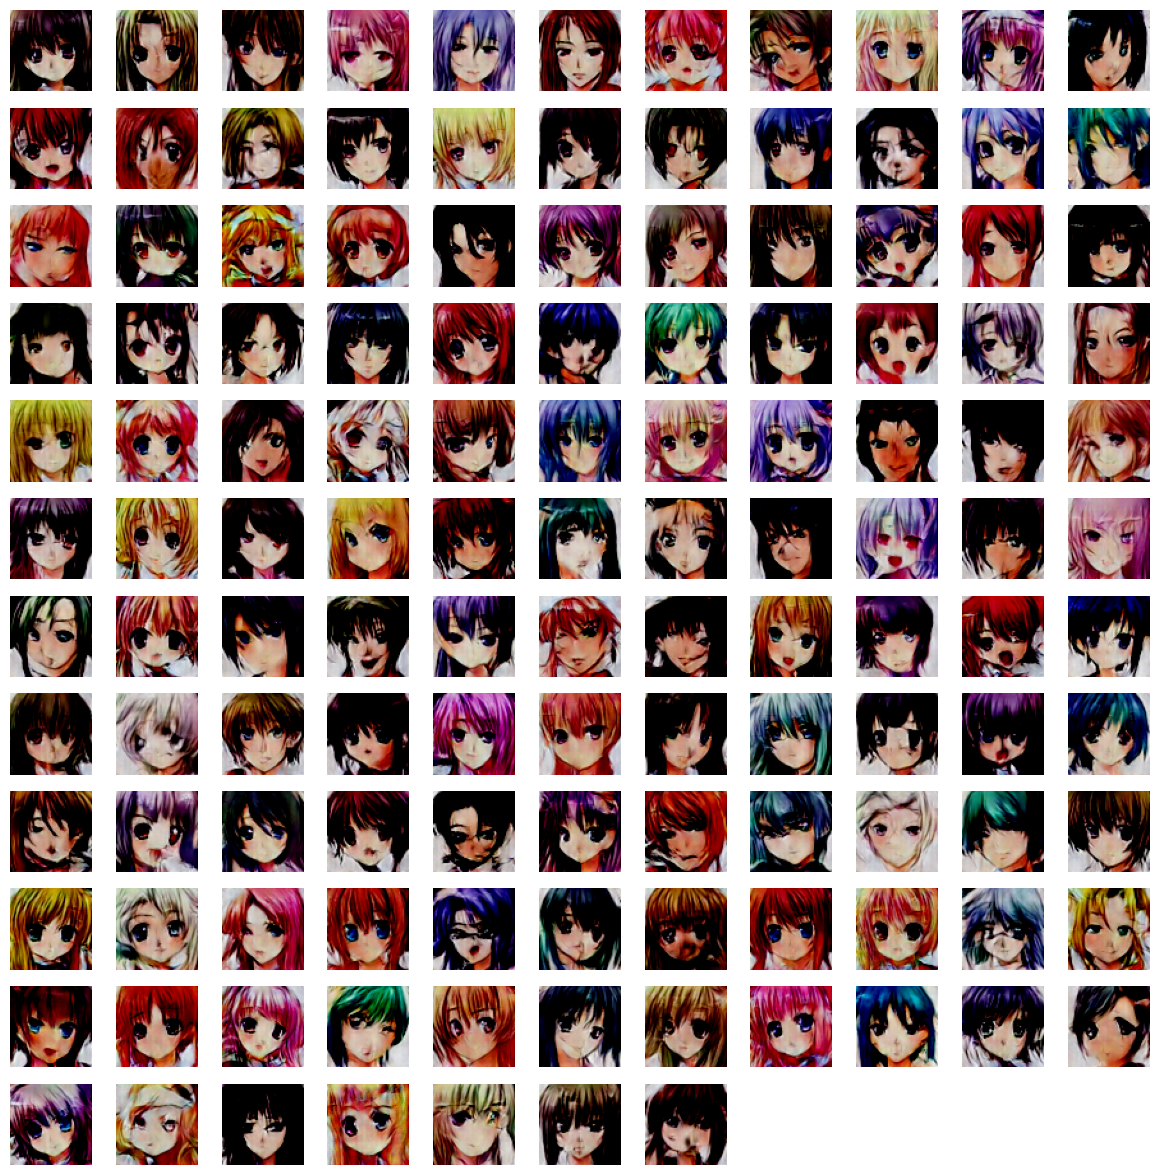

In [18]:

def generated_image_plot(fake_data, title="Generated Images Grid"):
    batch_size, channels, height, width = fake_data.shape

    num_rows = int(np.ceil(np.sqrt(batch_size)))
    num_cols = int(np.ceil(batch_size / num_rows))

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

    for i in range(batch_size):
        img = fake_data[i].cpu().detach().numpy()
        img = np.transpose(img, (1, 2, 0))
        ax = axes[i // num_cols, i % num_cols]
        ax.imshow(img)
        ax.axis("off")

    for i in range(batch_size, num_rows * num_cols):
        axes.flatten()[i].axis("off")

    plt.subplots_adjust(wspace=0.01)

    plt.show()
    batch_size, channels, height, width = fake_data.shape

generated_image_plot(fake_data)